In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

import Utils

In [2]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
X_DIM = 28
LATENT_DIM = 100
HIDDEN = 64
EPOCH_NUM = 300
lr = 0.001

In [3]:
device = Utils.get_device()
dataloader = Utils.get_loader(torchvision.datasets.MNIST, X_DIM, BATCH_SIZE, normalize=False)

Using device: cuda
Data loaded


## Sample images from the dataset

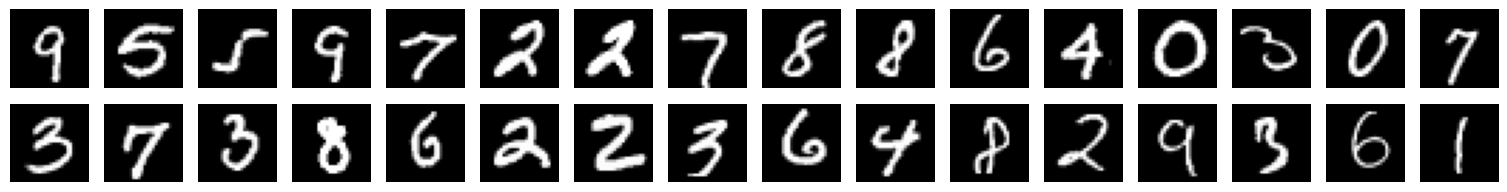

In [4]:
Utils.plot_real(dataloader, X_DIM)

## Model Architecture and Configuration

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, HIDDEN, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(HIDDEN),
            nn.LeakyReLU(0.1, inplace=True),  # shape: (HIDDEN, 14, 14)
            # 2nd layer
            nn.Conv2d(HIDDEN, HIDDEN * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(HIDDEN * 2),
            nn.LeakyReLU(0.1, inplace=True),  # shape: (HIDDEN * 2, 7, 7)
            # 3rd layer
            nn.Conv2d(HIDDEN * 2, HIDDEN * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(HIDDEN * 4),
            nn.LeakyReLU(0.1, inplace=True),  # shape: (HIDDEN * 4, 7, 7)
            nn.Flatten()  # shape: (HIDDEN * 4 * 7 * 7,)
        )
        output_dim = HIDDEN * 4 * 7 * 7
        self.mean = nn.Linear(output_dim, LATENT_DIM)
        self.log_var = nn.Linear(output_dim, LATENT_DIM)
        
    def forward(self, x):
        x = self.main(x)
        z_mean = self.mean(x)
        z_log_var = self.log_var(x)
        std = torch.exp(0.5 * z_log_var)
        epsilon = torch.randn(x.size(0), LATENT_DIM).to(device)
        z = z_mean + std * epsilon
        return z, z_mean, z_log_var

In [6]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Linear(LATENT_DIM, HIDDEN * 4 * 7 * 7),
            Reshape(HIDDEN * 4, 7, 7),
            nn.BatchNorm2d(HIDDEN * 4),
            nn.LeakyReLU(0.1),  # shape: (HIDDEN * 4, 7, 7)
            # 2nd layer
            nn.ConvTranspose2d(HIDDEN * 4, HIDDEN * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(HIDDEN * 2),
            nn.LeakyReLU(0.1),  # shape: (HIDDEN * 2, 7, 7) 
            # 3rd layer
            nn.ConvTranspose2d(HIDDEN * 2, HIDDEN, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(HIDDEN),
            nn.LeakyReLU(0.1),  # shape: (HIDDEN, 14, 14)
            # 4th layer
            nn.ConvTranspose2d(HIDDEN, IMAGE_CHANNEL, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # shape: (IMAGE_CHANNEL, 28, 28)
        )
        
    def forward(self, x):
        return self.main(x)
    
    def generate(self, cnt):
        z = torch.randn(cnt, LATENT_DIM).to(device)
        return self.main(z)

In [8]:
netE = Encoder().to(device)
print('Number of parameters in the encoder:', Utils.get_n_params(netE))

netD = Decoder().to(device)
print('Number of parameters in the decoder:', Utils.get_n_params(netD))

criterion = Utils.vae_loss
viz_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)

optimizer = torch.optim.Adam(list(netE.parameters()) + list(netD.parameters()), lr=lr, betas=(0.5, 0.999))

Number of parameters in the encoder: 2937352
Number of parameters in the decoder: 1695041


## Training loop

[1/300][468/469]	Loss: 11562.0645
[2/300][468/469]	Loss: 10747.3135
[3/300][468/469]	Loss: 10467.5078
[4/300][468/469]	Loss: 10043.0293
[5/300][468/469]	Loss: 9941.0615
[6/300][468/469]	Loss: 9748.9355
[7/300][468/469]	Loss: 9987.3867
[8/300][468/469]	Loss: 9596.0557
[9/300][468/469]	Loss: 10095.2178
[10/300][468/469]	Loss: 9392.3643
[11/300][468/469]	Loss: 9847.9941
[12/300][468/469]	Loss: 9729.8965
[13/300][468/469]	Loss: 9137.9629
[14/300][468/469]	Loss: 9515.2441
[15/300][468/469]	Loss: 9331.1289
[16/300][468/469]	Loss: 9471.2227
[17/300][468/469]	Loss: 9789.9707
[18/300][468/469]	Loss: 9432.7656
[19/300][468/469]	Loss: 9646.0137
[20/300][468/469]	Loss: 9410.9277
[21/300][468/469]	Loss: 9549.1152
[22/300][468/469]	Loss: 9317.6611
[23/300][468/469]	Loss: 9228.4766
[24/300][468/469]	Loss: 9701.7646
[25/300][468/469]	Loss: 9430.5020


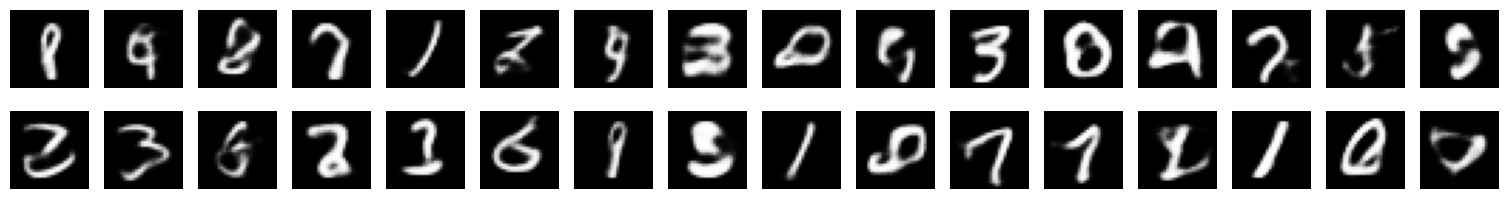

[26/300][468/469]	Loss: 9645.6074
[27/300][468/469]	Loss: 9273.7490
[28/300][468/469]	Loss: 9173.3818
[29/300][468/469]	Loss: 9268.6699
[30/300][468/469]	Loss: 9535.0508
[31/300][468/469]	Loss: 9373.6943
[32/300][468/469]	Loss: 9258.4805
[33/300][468/469]	Loss: 9169.4980
[34/300][468/469]	Loss: 9228.1943
[35/300][468/469]	Loss: 9031.0898
[36/300][468/469]	Loss: 9595.8721
[37/300][468/469]	Loss: 9287.3535
[38/300][468/469]	Loss: 9168.6621
[39/300][468/469]	Loss: 9295.1982
[40/300][468/469]	Loss: 8793.1318
[41/300][468/469]	Loss: 9768.2852
[42/300][468/469]	Loss: 9082.1240
[43/300][468/469]	Loss: 8870.8330
[44/300][468/469]	Loss: 9026.9766
[45/300][468/469]	Loss: 8747.7031
[46/300][468/469]	Loss: 8815.9785
[47/300][468/469]	Loss: 9361.6621
[48/300][468/469]	Loss: 9093.2041
[49/300][468/469]	Loss: 9024.7930
[50/300][468/469]	Loss: 9032.7852


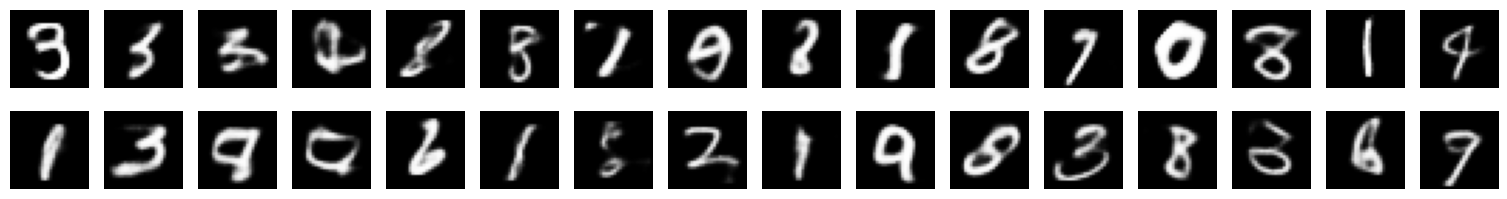

[51/300][468/469]	Loss: 9135.5020
[52/300][468/469]	Loss: 8848.9531
[53/300][468/469]	Loss: 9159.8877
[54/300][468/469]	Loss: 9203.9141
[55/300][468/469]	Loss: 9226.8291
[56/300][468/469]	Loss: 8862.1396
[57/300][468/469]	Loss: 8771.0586
[58/300][468/469]	Loss: 8947.5469
[59/300][468/469]	Loss: 9053.7090
[60/300][468/469]	Loss: 9106.0605
[61/300][468/469]	Loss: 8979.5898
[62/300][468/469]	Loss: 8390.0469
[63/300][468/469]	Loss: 9099.5723
[64/300][468/469]	Loss: 9193.1748
[65/300][468/469]	Loss: 9353.2480
[66/300][468/469]	Loss: 8906.2490
[67/300][468/469]	Loss: 8823.0215
[68/300][468/469]	Loss: 8722.9434
[69/300][468/469]	Loss: 8852.5977
[70/300][468/469]	Loss: 9565.4551
[71/300][468/469]	Loss: 8800.3633
[72/300][468/469]	Loss: 9042.0820
[73/300][468/469]	Loss: 8708.4668
[74/300][468/469]	Loss: 9083.1543
[75/300][468/469]	Loss: 8930.7119


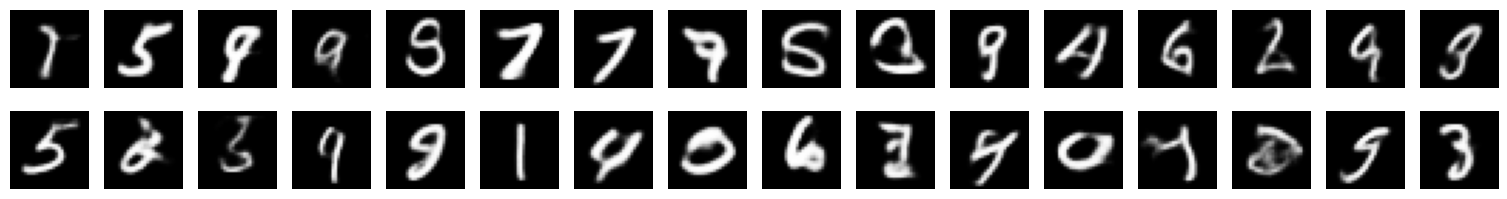

[76/300][468/469]	Loss: 8903.3125
[77/300][468/469]	Loss: 9326.3955
[78/300][468/469]	Loss: 9076.9307
[79/300][468/469]	Loss: 9088.1045
[80/300][468/469]	Loss: 8877.8037
[81/300][468/469]	Loss: 8988.7197
[82/300][468/469]	Loss: 9292.9854
[83/300][468/469]	Loss: 8958.3672
[84/300][468/469]	Loss: 9005.7598
[85/300][468/469]	Loss: 8907.3965
[86/300][468/469]	Loss: 8822.6621
[87/300][468/469]	Loss: 8539.5537
[88/300][468/469]	Loss: 9206.9326
[89/300][468/469]	Loss: 9345.4336
[90/300][468/469]	Loss: 8839.6729
[91/300][468/469]	Loss: 8660.4170
[92/300][468/469]	Loss: 8980.9258
[93/300][468/469]	Loss: 8818.2393
[94/300][468/469]	Loss: 8864.5195
[95/300][468/469]	Loss: 8826.1055
[96/300][468/469]	Loss: 9246.0059
[97/300][468/469]	Loss: 9078.6953
[98/300][468/469]	Loss: 8811.5957
[99/300][468/469]	Loss: 8414.0371
[100/300][468/469]	Loss: 8970.9766


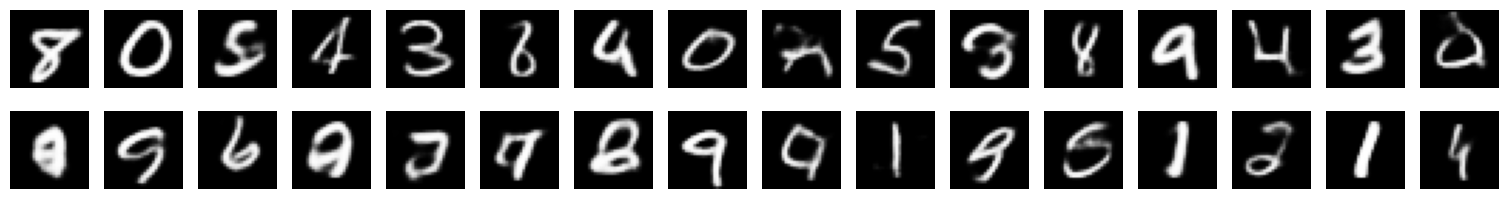

[101/300][468/469]	Loss: 9005.2598
[102/300][468/469]	Loss: 8868.1816
[103/300][468/469]	Loss: 8985.3486
[104/300][468/469]	Loss: 8879.5801
[105/300][468/469]	Loss: 9015.8643
[106/300][468/469]	Loss: 8511.3965
[107/300][468/469]	Loss: 8775.9648
[108/300][468/469]	Loss: 8862.9756
[109/300][468/469]	Loss: 8604.5059
[110/300][468/469]	Loss: 8382.5547
[111/300][468/469]	Loss: 8795.9014
[112/300][468/469]	Loss: 8932.2656
[113/300][468/469]	Loss: 9145.4668
[114/300][468/469]	Loss: 8842.7109
[115/300][468/469]	Loss: 8551.5000
[116/300][468/469]	Loss: 9046.6143
[117/300][468/469]	Loss: 8584.6328
[118/300][468/469]	Loss: 8633.1152
[119/300][468/469]	Loss: 8498.6035
[120/300][468/469]	Loss: 8876.6562
[121/300][468/469]	Loss: 8986.2998
[122/300][468/469]	Loss: 8551.8604
[123/300][468/469]	Loss: 8567.7832
[124/300][468/469]	Loss: 8300.1416
[125/300][468/469]	Loss: 9374.9473


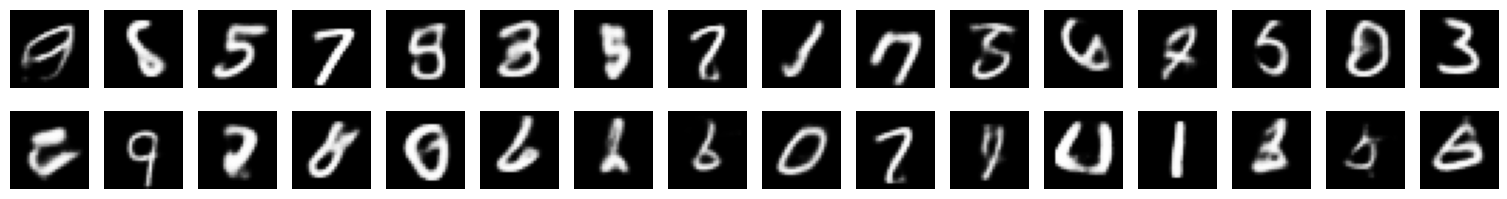

[126/300][468/469]	Loss: 8890.3984
[127/300][468/469]	Loss: 8558.7061
[128/300][468/469]	Loss: 8474.7539
[129/300][468/469]	Loss: 8522.9082
[130/300][468/469]	Loss: 8693.2822
[131/300][468/469]	Loss: 8480.8242
[132/300][468/469]	Loss: 8590.9961
[133/300][468/469]	Loss: 8980.7344
[134/300][468/469]	Loss: 8757.9541
[135/300][468/469]	Loss: 8403.2139
[136/300][468/469]	Loss: 8967.0596
[137/300][468/469]	Loss: 8443.5166
[138/300][468/469]	Loss: 8751.9414
[139/300][468/469]	Loss: 8622.8076
[140/300][468/469]	Loss: 9010.6201
[141/300][468/469]	Loss: 8651.7031
[142/300][468/469]	Loss: 8985.5068
[143/300][468/469]	Loss: 8530.3477
[144/300][468/469]	Loss: 8697.0146
[145/300][468/469]	Loss: 8765.9766
[146/300][468/469]	Loss: 8112.7534
[147/300][468/469]	Loss: 9386.7246
[148/300][468/469]	Loss: 8668.0957
[149/300][468/469]	Loss: 8490.3770
[150/300][468/469]	Loss: 8395.4023


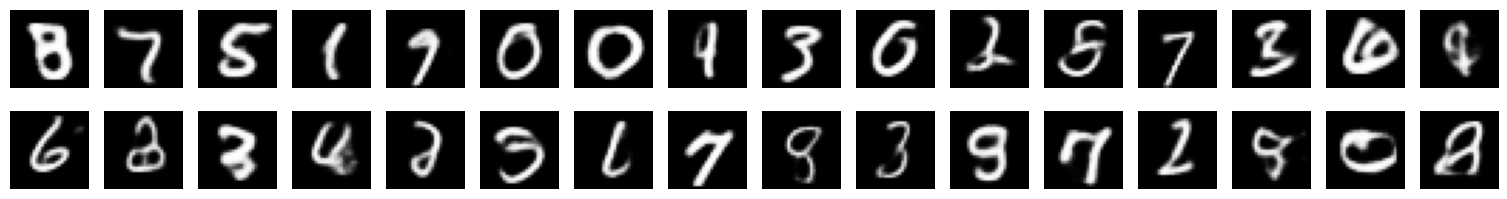

[151/300][468/469]	Loss: 8508.8516
[152/300][468/469]	Loss: 8567.1182
[153/300][468/469]	Loss: 8661.9336
[154/300][468/469]	Loss: 8443.0039
[155/300][468/469]	Loss: 8503.1348
[156/300][468/469]	Loss: 8696.0527
[157/300][468/469]	Loss: 8896.7031
[158/300][468/469]	Loss: 8953.8691
[159/300][468/469]	Loss: 9003.5459
[160/300][468/469]	Loss: 8885.7734
[161/300][468/469]	Loss: 8781.1523
[162/300][468/469]	Loss: 9119.7793
[163/300][468/469]	Loss: 8619.0977
[164/300][468/469]	Loss: 9140.8906
[165/300][468/469]	Loss: 8876.1602
[166/300][468/469]	Loss: 8357.8604
[167/300][468/469]	Loss: 8658.9092
[168/300][468/469]	Loss: 8918.0518
[169/300][468/469]	Loss: 8826.5986
[170/300][468/469]	Loss: 8377.0947
[171/300][468/469]	Loss: 8649.9258
[172/300][468/469]	Loss: 8642.8203
[173/300][468/469]	Loss: 8898.9004
[174/300][468/469]	Loss: 8699.2861
[175/300][468/469]	Loss: 8614.9854


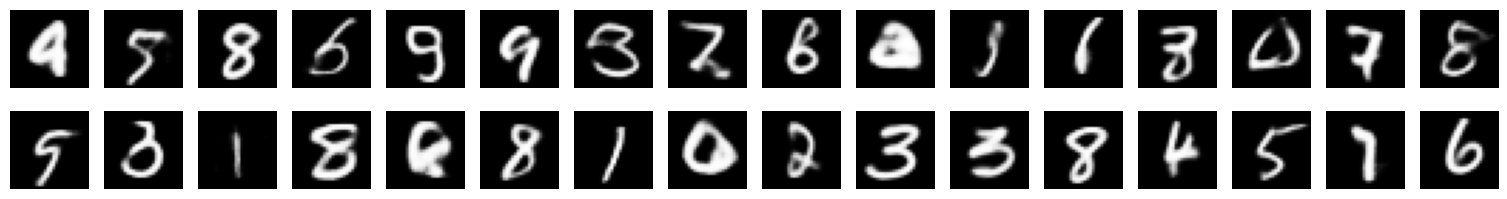

[176/300][468/469]	Loss: 8726.9121
[177/300][468/469]	Loss: 8732.9688
[178/300][468/469]	Loss: 8556.7256
[179/300][468/469]	Loss: 8747.0439
[180/300][468/469]	Loss: 8913.1465
[181/300][468/469]	Loss: 8640.3477
[182/300][468/469]	Loss: 8742.8828
[183/300][468/469]	Loss: 8789.1094
[184/300][468/469]	Loss: 8486.9121
[185/300][468/469]	Loss: 8704.6846
[186/300][468/469]	Loss: 8602.1172
[187/300][468/469]	Loss: 8886.4473
[188/300][468/469]	Loss: 8600.3906
[189/300][468/469]	Loss: 8733.4395
[190/300][468/469]	Loss: 8500.8984
[191/300][468/469]	Loss: 9255.3203
[192/300][468/469]	Loss: 8612.1025
[193/300][468/469]	Loss: 8869.7812
[194/300][468/469]	Loss: 8937.9766
[195/300][468/469]	Loss: 8647.2578
[196/300][468/469]	Loss: 8431.8965
[197/300][468/469]	Loss: 8527.2109
[198/300][468/469]	Loss: 8777.8643
[199/300][468/469]	Loss: 8469.6914
[200/300][468/469]	Loss: 8111.1309


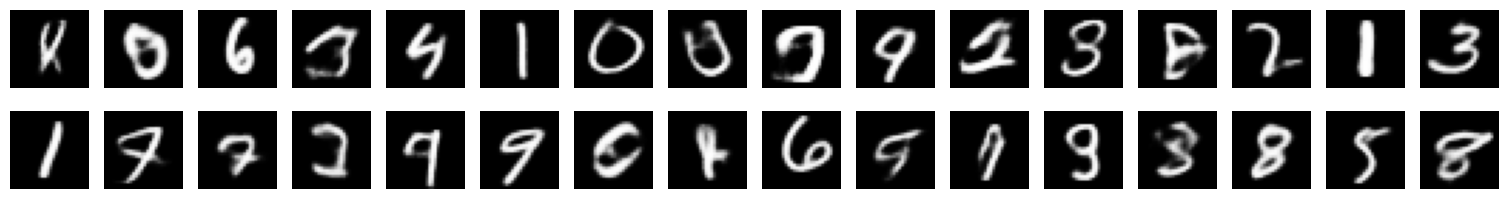

[201/300][468/469]	Loss: 8978.5137
[202/300][468/469]	Loss: 8733.7090
[203/300][468/469]	Loss: 8530.2266
[204/300][468/469]	Loss: 8771.0254
[205/300][468/469]	Loss: 8592.6914
[206/300][468/469]	Loss: 8788.7656
[207/300][468/469]	Loss: 8546.4424
[208/300][468/469]	Loss: 8806.1143
[209/300][468/469]	Loss: 8287.6592
[210/300][468/469]	Loss: 8638.1416
[211/300][468/469]	Loss: 8507.9229
[212/300][468/469]	Loss: 8524.1074
[213/300][468/469]	Loss: 8689.1230
[214/300][468/469]	Loss: 9206.3594
[215/300][468/469]	Loss: 8780.4277
[216/300][468/469]	Loss: 8530.6709
[217/300][468/469]	Loss: 8775.4717
[218/300][468/469]	Loss: 8702.0801
[219/300][468/469]	Loss: 8449.0400
[220/300][468/469]	Loss: 8374.6543
[221/300][468/469]	Loss: 8643.9766
[222/300][468/469]	Loss: 8247.3281
[223/300][468/469]	Loss: 8401.9209
[224/300][468/469]	Loss: 8373.9316
[225/300][468/469]	Loss: 8915.9521


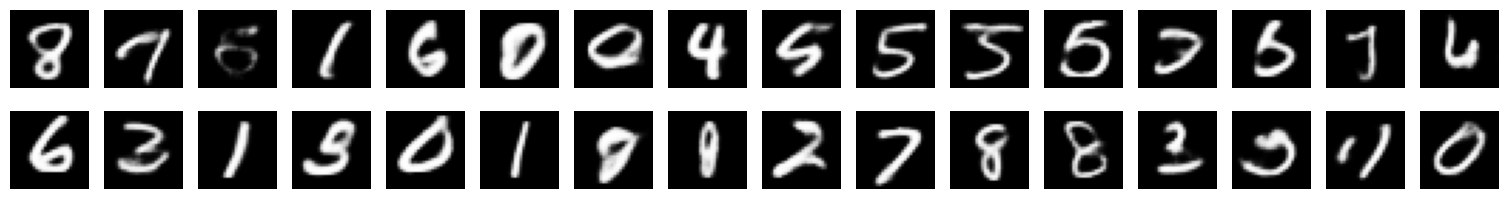

[226/300][468/469]	Loss: 8662.7910
[227/300][468/469]	Loss: 8606.9609
[228/300][468/469]	Loss: 8735.7715
[229/300][468/469]	Loss: 8650.0732
[230/300][468/469]	Loss: 8575.6309
[231/300][468/469]	Loss: 8844.2314
[232/300][468/469]	Loss: 8564.2969
[233/300][468/469]	Loss: 8705.1855
[234/300][468/469]	Loss: 8577.9883
[235/300][468/469]	Loss: 8693.5371
[236/300][468/469]	Loss: 8490.6201
[237/300][468/469]	Loss: 8676.7246
[238/300][468/469]	Loss: 8543.1445
[239/300][468/469]	Loss: 8351.2227
[240/300][468/469]	Loss: 8461.7617
[241/300][468/469]	Loss: 9085.5781
[242/300][468/469]	Loss: 8528.4609
[243/300][468/469]	Loss: 8601.1250
[244/300][468/469]	Loss: 8565.6836
[245/300][468/469]	Loss: 8853.5752
[246/300][468/469]	Loss: 8385.1230
[247/300][468/469]	Loss: 8652.9082
[248/300][468/469]	Loss: 8380.4482
[249/300][468/469]	Loss: 8968.3301
[250/300][468/469]	Loss: 8485.9775


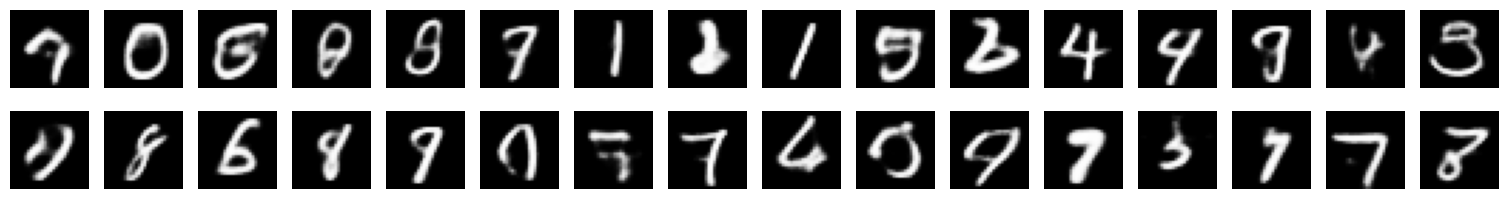

[251/300][468/469]	Loss: 8606.7754
[252/300][468/469]	Loss: 8639.2773
[253/300][468/469]	Loss: 8877.4082
[254/300][468/469]	Loss: 8478.0215
[255/300][468/469]	Loss: 8629.0703
[256/300][468/469]	Loss: 8786.6836
[257/300][468/469]	Loss: 8814.8535
[258/300][468/469]	Loss: 9081.1299
[259/300][468/469]	Loss: 8625.1211
[260/300][468/469]	Loss: 8405.2637
[261/300][468/469]	Loss: 8656.8672
[262/300][468/469]	Loss: 8539.8555
[263/300][468/469]	Loss: 8672.1211
[264/300][468/469]	Loss: 8704.7031
[265/300][468/469]	Loss: 8401.5479
[266/300][468/469]	Loss: 8827.9062
[267/300][468/469]	Loss: 8507.9209
[268/300][468/469]	Loss: 8945.8389
[269/300][468/469]	Loss: 8781.3770
[270/300][468/469]	Loss: 8504.7324
[271/300][468/469]	Loss: 8755.9297
[272/300][468/469]	Loss: 8497.1543
[273/300][468/469]	Loss: 8326.1660
[274/300][468/469]	Loss: 8579.6738
[275/300][468/469]	Loss: 8229.6230


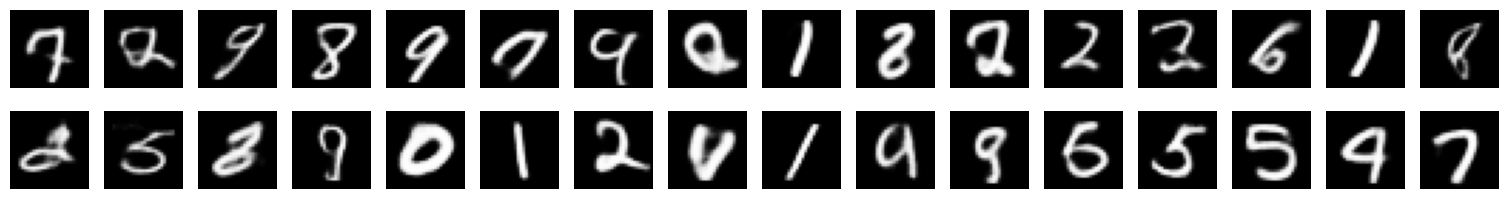

[276/300][468/469]	Loss: 8483.4648
[277/300][468/469]	Loss: 8503.2559
[278/300][468/469]	Loss: 8571.8291
[279/300][468/469]	Loss: 8952.5908
[280/300][468/469]	Loss: 8956.3789
[281/300][468/469]	Loss: 8655.3535
[282/300][468/469]	Loss: 8565.1602
[283/300][468/469]	Loss: 8572.9561
[284/300][468/469]	Loss: 8750.9043
[285/300][468/469]	Loss: 8548.6660
[286/300][468/469]	Loss: 8681.0498
[287/300][468/469]	Loss: 8845.4600
[288/300][468/469]	Loss: 9013.4678
[289/300][468/469]	Loss: 8898.1523
[290/300][468/469]	Loss: 8383.0547
[291/300][468/469]	Loss: 8840.6543
[292/300][468/469]	Loss: 8583.4111
[293/300][468/469]	Loss: 8939.8770
[294/300][468/469]	Loss: 8552.4980
[295/300][468/469]	Loss: 8296.7344
[296/300][468/469]	Loss: 8838.3125
[297/300][468/469]	Loss: 9011.6650
[298/300][468/469]	Loss: 8950.8389
[299/300][468/469]	Loss: 8322.2100
[300/300][468/469]	Loss: 8531.0557


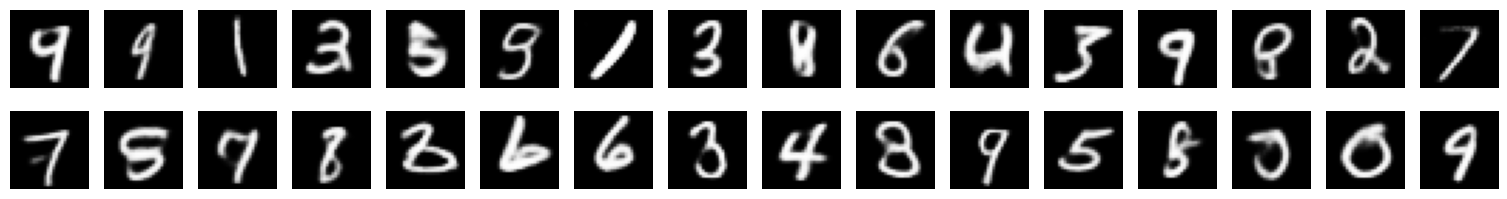

In [10]:
Utils.VAE_train(netE, netD, optimizer, criterion, dataloader, EPOCH_NUM, device)

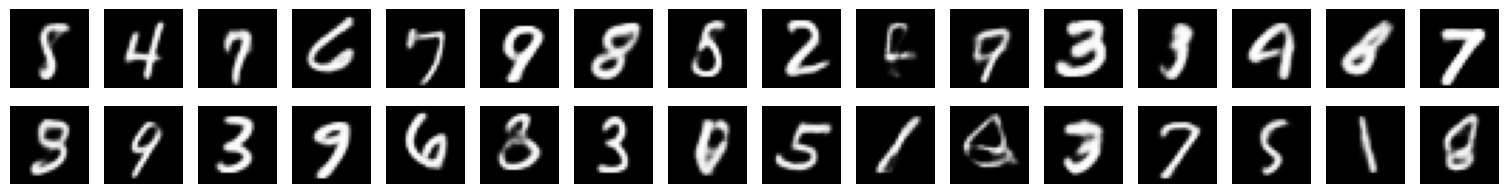

In [11]:
Utils.plot_images(netD.generate(64).detach().cpu().reshape(-1, 28, 28, 1), vmin=0, vmax=1, columns=16, height=1.2, 
                  width=1.2)

## Saving the model

In [16]:
model = nn.Sequential(netD, nn.Upsample(size=56, mode='nearest'))  # Upsampling the images to 56x56
dummy_input = torch.randn(1, LATENT_DIM).to(device)
Utils.save_model(model, dummy_input, 'VAE_MNIST')